In [1]:
import zipfile
import os
import subprocess
import shutil
import sys
home_directory = os.getcwd()


if not os.path.exists('cocoapi'):
    try:
        git_clone3 = '''
                    git clone https://github.com/cocodataset/cocoapi.git
                    '''
        subprocess.run([git_clone3], check=True, shell=True)
        
        os.chdir('cocoapi/PythonAPI')
        
        subprocess.run(['make'], check=True, shell=True)

        os.chdir(home_directory)
    except:
        print('cocoapi repo no se pudo clonar e instalar')
# else:        
#     try:
#         os.chdir('cocoapi/PythonAPI')
#         subprocess.run(['make'], check=True, shell=True)
#         os.chdir(home_directory)
#     except:
#         print('no se instaló cocoapi')
        
sys.path += [home_directory+'/cocoapi/PythonAPI']      
from pycocotools.coco import COCO
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pycocotools.coco import COCO
from PIL import Image
import matplotlib.patches as patches

if not os.path.exists('detectron2'):
    try:
        git_clone = '''
                    git clone https://github.com/facebookresearch/detectron2.git
                    '''
        subprocess.run([git_clone], check=True, shell=True)
    except:
        print('Detectron repo no se pudo clonar')

## Instala detectron2
# !python -m pip install pyyaml==5.1
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'     
    
# Añadimos las librerías al PYTHONPATH 
sys.path += [home_directory+'/PubLayNet',home_directory+'/detectron2', home_directory+'/Detectron']
# ! export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/PubLayNet:`pwd`/Detectron:`pwd`/detectron2:`pwd`/cocoapi/PythonAPI


#~~~~ REINICIA EL KERNEL DESPUÉS DE LAS INSTALACIONES ~~~~~

In [5]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

# Some basic setup:
# Setup detectron2 logger
# import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from pytesseract import pytesseract

In [ ]:
# https://towardsdatascience.com/analyzing-document-layout-with-layoutparser-ed24d85f1d44
# Calcular el IOU de las boxes para quitar las que están repetidas y mejorar la predicción
# https://medium.com/skilai/combining-optical-character-recognition-and-object-detection-for-document-processing-e8b9c488d9eb
# https://medium.com/pythoneers/text-detection-and-extraction-from-image-with-python-5c0c75a8ff14

In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/home/ec2-user/SageMaker/ocr/coco_annotations/annotation_train.json", "/home/ec2-user/SageMaker/ocr/data/train")
register_coco_instances("my_dataset_val", {}, "/home/ec2-user/SageMaker/ocr/coco_annotations/annotation_val.json", "/home/ec2-user/SageMaker/ocr/data/val")
register_coco_instances("my_dataset_test", {}, "/home/ec2-user/SageMaker/ocr/coco_annotations/annotation_test.json", "/home/ec2-user/SageMaker/ocr/data/test")

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TEST = ("my_dataset_test")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13  # ( https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

## INFERENCIA
# cambiamos un poco cfg para la inferencia
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path al modelo recién entrenado
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # establecemos un threshold de score

# Esto es para suprimir las boxes con un IoU mayor o igual que este threshold
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

In [54]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts_test = DatasetCatalog.get("my_dataset_test")
mydataset_metadata_test = MetadataCatalog.get("my_dataset_test")

## Guardamos el label map para traducir los índices a clases
dict_metadata = mydataset_metadata_test.as_dict()

label_map = {}
for i, value in enumerate(dict_metadata['thing_dataset_id_to_contiguous_id']):
    clase = dict_metadata['thing_classes'][i]
    nr_clase = dict_metadata['thing_dataset_id_to_contiguous_id'][value]

    label_map[nr_clase] = clase
    
label_map

[08/31 18:52:48 d2.data.datasets.coco]: Loaded 5276 images in COCO format from /home/ec2-user/SageMaker/ocr/coco_annotations/annotation_test.json


{0: 'paragraph',
 1: 'reference',
 2: 'equation',
 3: 'list',
 4: 'section',
 5: 'caption',
 6: 'figure',
 7: 'footer',
 8: 'abstract',
 9: 'table',
 10: 'title',
 11: 'author',
 12: 'date'}

In [36]:
# Voy guardando sobre las que podría hacer OCR
list_img = ['/home/ec2-user/SageMaker/ocr/data/test/106.tar_1507.02619.gz_tori_5_ori.jpg',
           '/home/ec2-user/SageMaker/ocr/data/test/112.tar_1804.08763.gz_paper_2_ori.jpg']

'/home/ec2-user/SageMaker/ocr/data/test/106.tar_1507.02619.gz_tori_5_ori.jpg'

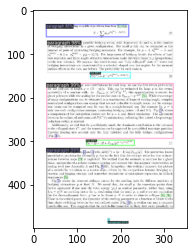

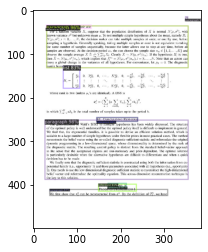

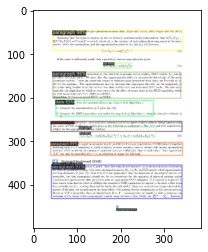

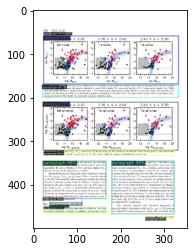

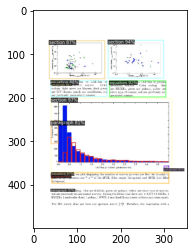

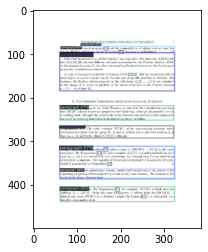

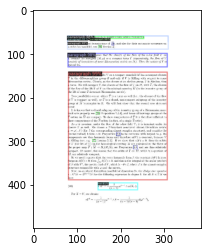

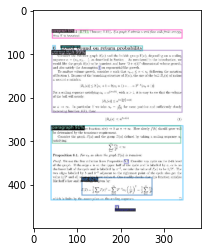

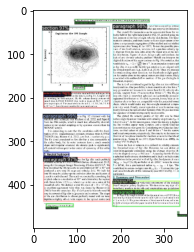

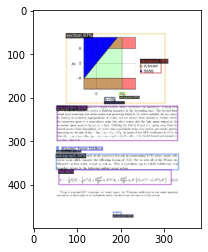

In [71]:
## Guardamos crops detectados por el modelo de localización
## Estos serán sobre los que apliquemos el OCR

for d in random.sample(dataset_dicts_test, 10):    
    im = cv2.imread(d["file_name"])
    img_name_full =  d['file_name']
    img_name = img_name_full.split('/')[-1].split('.jpg')[0]
    outputs = predictor(im)  # https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=mydataset_metadata_test, 
                   scale=0.5,      
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    np_image = out.get_image()[:, :, ::-1]
    plt.imshow(np_image)
#     mpimg.imsave(home_directory + '/images/{}_pred_test.jpg'.format(img_name), np_image)
    plt.show()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## Crop de las anotaciones, para aplicar OCR sobre una pieza concreta
    for i in range(len(outputs['instances'])):
        # (x1, y1, x2, y2)
        image = mpimg.imread(img_name_full)

        x0 = int(outputs["instances"].pred_boxes.tensor.cpu().numpy()[i][0])
        y0 = int(outputs["instances"].pred_boxes.tensor.cpu().numpy()[i][1])
        x1 = int(outputs["instances"].pred_boxes.tensor.cpu().numpy()[i][2])
        y1 = int(outputs["instances"].pred_boxes.tensor.cpu().numpy()[i][3])

        crop = image[y0:y1, x0:x1, :]
#         plt.imshow(crop)

        ## Guardamos la clase en el nombre del crop
        idx_class = outputs['instances'].pred_classes.cpu().numpy()[i]
        clase = label_map[idx_class]
    
        mpimg.imsave(home_directory + '/crops/{}_{}__{}.png'.format(i, img_name, clase), crop)

        plt.show()
        
## Zip de los crops 
# ! zip -r crops.zip /home/ec2-user/SageMaker/ocr/crops

In [46]:
# ## Crop de las anotaciones, para aplicar OCR sobre una pieza concreta

# for i in [0]: #range(len(outputs['instances'])):

#     # (x1, y1, x2, y2)
#     img_name = d['file_name']
#     image = mpimg.imread(img_name)

#     x0 = int(outputs["instances"].pred_boxes.tensor.cpu().numpy()[i][0])
#     y0 = int(outputs["instances"].pred_boxes.tensor.cpu().numpy()[i][1])
#     x1 = int(outputs["instances"].pred_boxes.tensor.cpu().numpy()[i][2])
#     y1 = int(outputs["instances"].pred_boxes.tensor.cpu().numpy()[i][3])

#     crop = image[y0:y1, x0:x1, :]
#     plt.imshow(crop)
#     plt.show()